# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [523]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import LabelEncoder
# %matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [524]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [525]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [526]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


# Data Exploration and Exploratory Visualization

As part of this project, before write some code or make some predictions, is neccessary understand in deep the data and all the attibutes as well as the influence between the attibutes.

In [527]:
import matplotlib.pyplot as plt

### Transactions

Now we will analyse the transactions data begining with a histogram, to check the difference about the events.

<AxesSubplot:xlabel='event'>

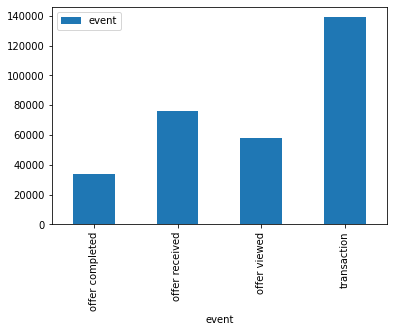

In [528]:
transcript_count_event = transcript.groupby('event').count()
transcript_count_event = transcript_count_event.drop(['value', 'time'], axis=1)
transcript_count_event = transcript_count_event.rename(columns={'person':'event'})
transcript_count_event.plot.bar()

<AxesSubplot:>

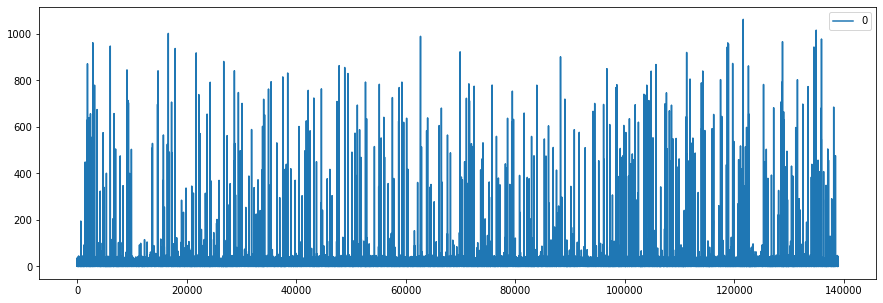

In [529]:
transcript_transaction = transcript.query("event == 'transaction'")
values = []
for value in transcript_transaction['value'].values:
    values.append(value['amount'])
transcript_value_only = pd.DataFrame(values)
transcript_value_only.plot(figsize=(15,5))

<AxesSubplot:xlabel='time'>

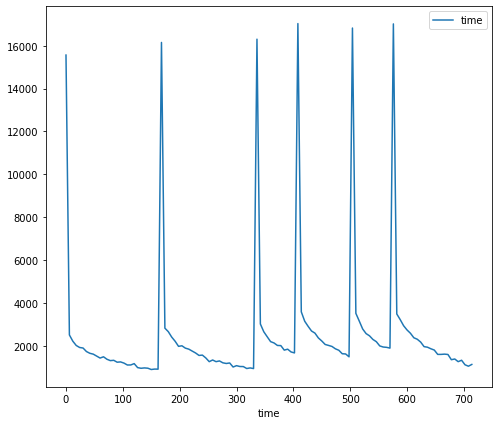

In [530]:
transcrit_count_income = transcript.groupby('time').count()
transcrit_count_income = transcrit_count_income.drop(['value', 'event'], axis=1)
transcrit_count_income = transcrit_count_income.rename(columns={'person':'time'})
transcrit_count_income.plot(figsize=(8,7))

### Demographic
Analyse of the demographic data, to check the difference about the age, gender, incame and other attributes.

<AxesSubplot:xlabel='age'>

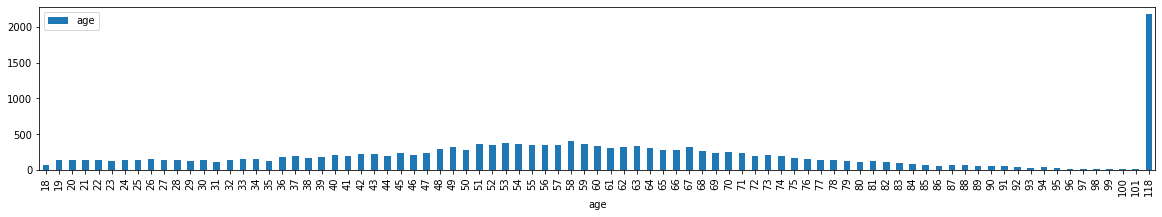

In [531]:
demographi_count_age = profile.groupby('age').count()
demographi_count_age = demographi_count_age.drop(['gender', 'became_member_on', 'income'], axis=1)
demographi_count_age = demographi_count_age.rename(columns={'id':'age'})
demographi_count_age.plot.bar(figsize=(20,3))

With the graph above we  can see that the age 118 is not correct and is out of the pattern. After remove it, we have the graph below.

<AxesSubplot:xlabel='age'>

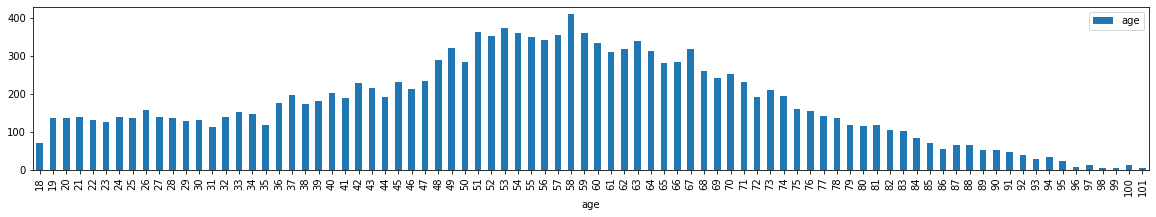

In [532]:
# Remove last element of Dataframe demographi_count and then plot the graph
demographi_count_age = demographi_count_age[:-1]
demographi_count_age.plot.bar(figsize=(20,3))

In [533]:
# Now we remove the age 118 from the original Dataframe profile
profile = profile.query("age != 118")

In the graph below we can visualize the proportion between the Genders

<AxesSubplot:xlabel='gender'>

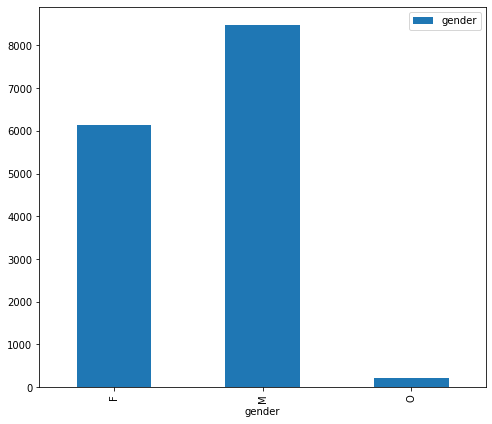

In [534]:
demographi_count_gender = profile.groupby('gender').count()
demographi_count_gender = demographi_count_gender.drop(['age', 'became_member_on', 'income'], axis=1)
demographi_count_gender = demographi_count_gender.rename(columns={'id':'gender'})
demographi_count_gender.plot.bar(figsize=(8,7))

In the graph below we can visualize the proportion between the Incomes

<AxesSubplot:xlabel='income'>

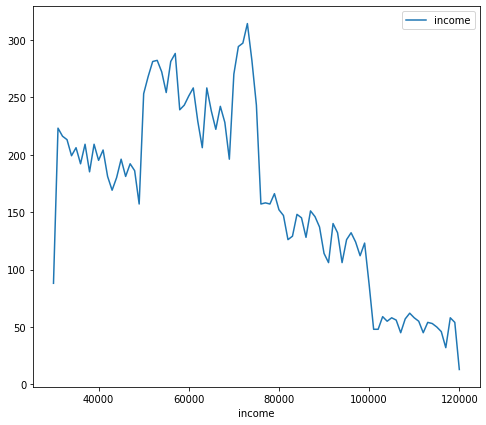

In [535]:
demographi_count_income = profile.groupby('income').count()
demographi_count_income = demographi_count_income.drop(['age', 'became_member_on', 'gender'], axis=1)
demographi_count_income = demographi_count_income.rename(columns={'id':'income'})
demographi_count_income.plot(figsize=(8,7))

### Portifolio Offers

Analyse of the offers data. Here we  have just 10  elements, thus we didn't need to plot any graphp because it is easy to visualize all of them.

In [536]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Algorithms and Techniques

Here we  will discuss about the Artificial Neural Network (ANN) and and the Random Forest and how we can use it in our project.

### Artificial Neural Network

Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.

Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

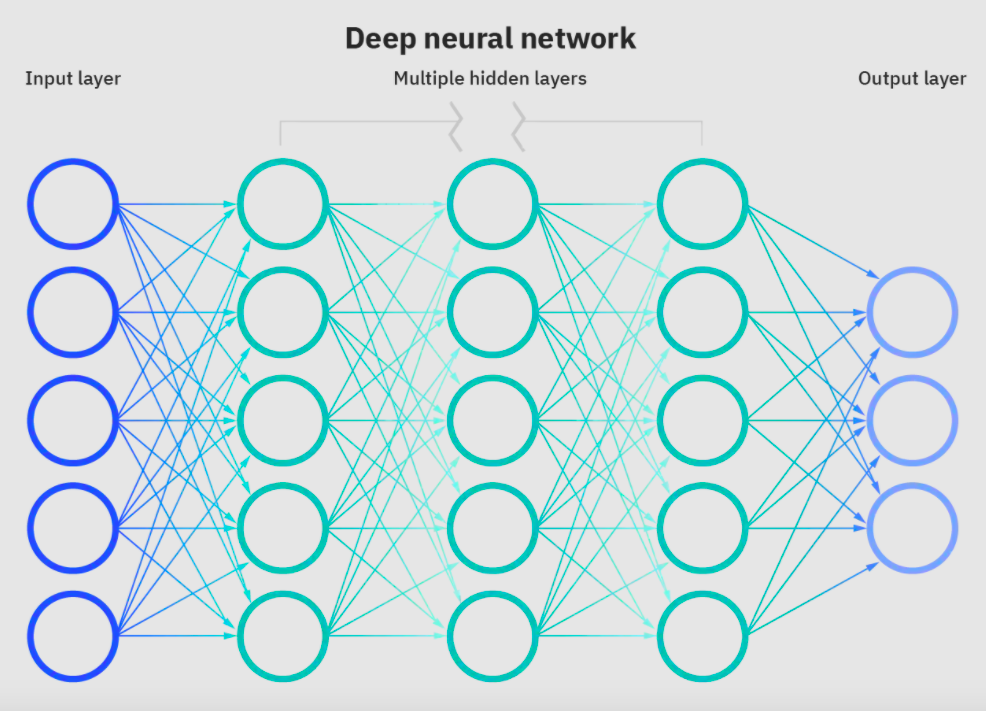

In [537]:
from IPython import display
display.Image("./images/ann.png")

Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.



A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

In our project we eill use the library Keras


### Random Forest

Random forest is a flexible, easy to use machine learning algorithm that produces, even without hyper-parameter tuning, a great result most of the time. It is also one of the most used algorithms, because of its simplicity and diversity (it can be used for both classification and regression tasks). In this post we'll learn how the random forest algorithm works, how it differs from other algorithms and how to use it.

Random forest is a supervised learning algorithm. The "forest" it builds, is an ensemble of decision trees, usually trained with the “bagging” method. The general idea of the bagging method is that a combination of learning models increases the overall result.

One big advantage of random forest is that it can be used for both classification and regression problems, which form the majority of current machine learning systems. In our case we will use the classification; Let's look at random forest in classification, since classification is sometimes considered the building block of machine learning. Below you can see how a random forest would look like with two trees:

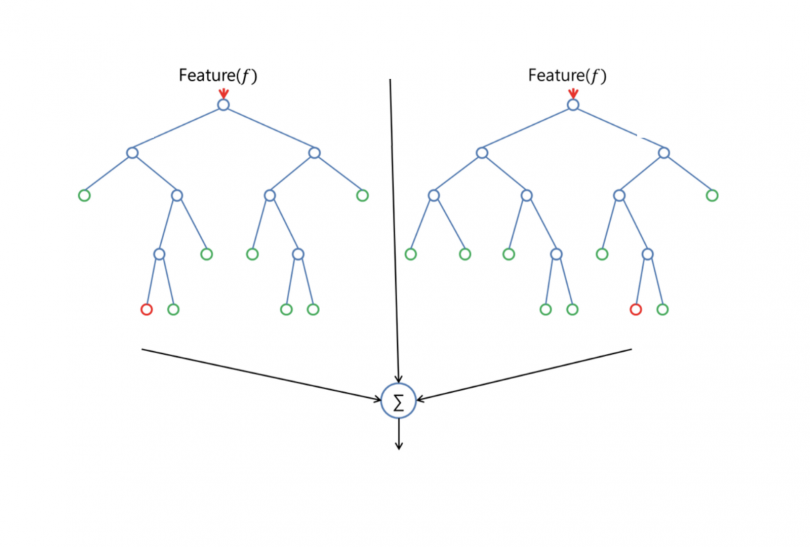

In [538]:
display.Image("./images/randomforest.png")

# Benchmark

To have some paraters and define a border to our performance, we search at the literature limilar works. 

Stubseid and Arandjelovic (2018) studied about how consumers make decisions before to buy a product.

Using a large real world data set, they present a series of experiments, analyse and compare the performances of different machine learning techniques, and discuss the significance of the findings in the context of public policy
and consumer education. As the result of their work, there are the tables bellow:

The figure below shows the instance structure used in their work

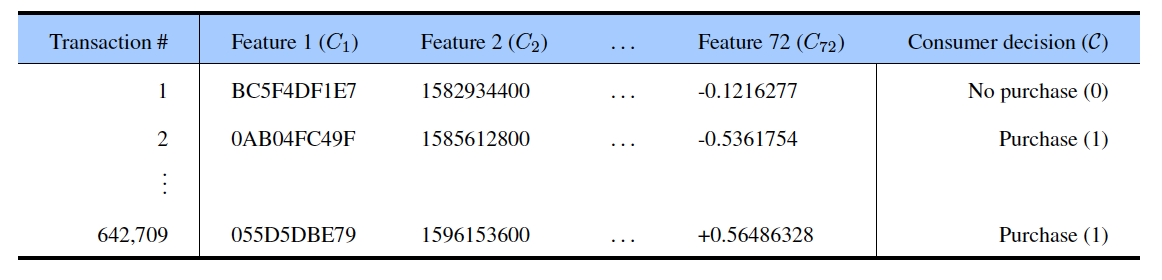

In [539]:
display.Image("./images/paper1.png")

The figure below shows the results obtained in their work

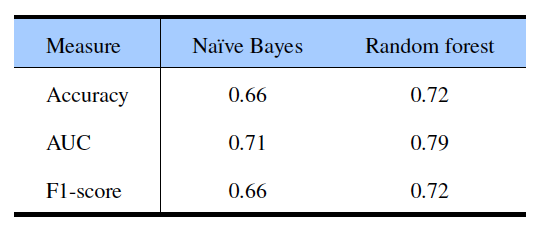

In [540]:
display.Image("./images/paper2.png")

Although the dataset used by Stubseid and Arandjelovic (2018) being different from the dataset used in this work, we can measure and hope how good our perfamance can being. 

# Data Preprocessing

Data preprocessing is a data mining technique that involves transforming raw data into an understandable format. Real-world data is often incomplete, inconsistent, lacking in certain behaviors or trends, and is likely to contain many errors.

Data preprocessing is a proven method of resolving such issues. Data preprocessing prepares raw data for further processing.
Data preprocessing is used in database-driven applications such as customer relationship management and rule-based applications (like neural networks).
In Machine Learning (ML) processes, data preprocessing is critical to encode the dataset in a form that could be interpreted and parsed by the algorithm.



For example, when we remove the age 118 from the dataset profile.json, we made our first Preprocessing in our data. But some other manipultation is necessary yet before runing the algorithm.

#### Firstly we will work with the dataset portfolio.

In [541]:
portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


We will make the follow steps:
- Tranform the offer_type in integers
- Create 4 new attibutes from channels

#### Create 4 new attibutes from channels

In [542]:
def add_channels_portfolio(portfolio):
    new_portfolio = []
    for i in portfolio.values.tolist():
            
        lis = (i[1])
        if type(lis) == list and len(lis) > 0:
            if ('web' in lis):
                i.append(1)
            else:
                i.append(0)

            if ('email' in lis):
                i.append(1)
            else:
                i.append(0)

            if ('mobile' in lis):
                i.append(1)
            else:
                i.append(0)

            if ('social' in lis):
                i.append(1)
            else:
                i.append(0)


        # add new channels into new_portfolio
        new_portfolio.append(i)
        
    return new_portfolio

In [543]:
columns = portfolio.columns
columns =columns.append(pd.Index(['web']))
columns = columns.append(pd.Index(['email']))
columns = columns.append(pd.Index(['mobile']))
columns = columns.append(pd.Index(['social']))

new_portfolio = add_channels_portfolio(portfolio)
new_portfolio = pd.DataFrame(np.array(new_portfolio))

new_portfolio.columns = columns

/home/jlima/Documents/jupyter/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


#### Tranform the offer_type in integers

In [544]:

lb_make = LabelEncoder()
new_portfolio["make_code"] = lb_make.fit_transform(new_portfolio["offer_type"])
del new_portfolio["offer_type"]

new_portfolio = new_portfolio.rename(columns={'make_code':'offer_type'})

The the code has this result: 
- Class 0 = bogo
- Class 1 = discount
- Class 2 = informational

#### Removing attribute channels from portfolio

In [545]:
new_portfolio = new_portfolio.drop(['channels'], axis=1)


In [546]:
new_portfolio.head(3)

,reward,difficulty,duration,id,web,email,mobile,social,offer_type
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,2


### Now we will work with the dataset profile.

In [547]:
profile.head(3)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0


Here we will make the follow steps:
- We already removed the samples with age 118
- Divide the attribute income in 3 groups
- Divide the attribute age in 3 groups
- Transform gender in integers
- Transform atribute became_member_on in days and then, divide it in 3 groups

#### Divide the attribute income in 3 groups

In [548]:
print(min(profile['income']))
print(max(profile['income']))

30000.0
120000.0


In [549]:
def get_income_groups(df):
    df["income"] = pd.cut(x=df['income'], bins=[0,60000,90000,120000], labels=[1,2,3])
    return df

# Call function
new_profile = get_income_groups(profile)

#### Divide the attribute age in 3 groups

In [550]:
print(min(profile['age']))
print(max(profile['age']))

18
101


In [551]:
def get_income_groups(df):
    df["age"] = pd.cut(x=df['age'], bins=[0,30,60,110], labels=[1,2,3])
    return df

# Call function
new_profile = get_income_groups(profile)

#### Tranform gender in integer

In [552]:

lb_make = LabelEncoder()
new_profile["make_code"] = lb_make.fit_transform(new_profile["gender"])
del new_profile["gender"]

new_profile = new_profile.rename(columns={'make_code':'gender'})

The the code has this result: 
- Class 0 = F
- Class 1 = M
- Class 2 = O

#### Transform atribute became_member_on in days and then, divide it in 3 groups

In [553]:
new_profile['new_became_member'] = pd.to_datetime(new_profile['became_member_on'],format='%Y%m%d')

new_profile['today'] = pd.to_datetime("today")

new_profile['days_became_member'] = (new_profile['today'] - new_profile['new_became_member']).dt.days

In [554]:
print(min(new_profile['days_became_member']))
print(max(new_profile['days_became_member']))

1081
2904


In [555]:
def get_became_member_groups(df):
    df["days_became_member"] = pd.cut(x=df['days_became_member'], bins=[0,1600,2200,3000], labels=[1,2,3])
    return df

# Call function
new_profile = get_became_member_groups(new_profile)

In [556]:
del new_profile['today']
del new_profile['new_became_member']
del new_profile['became_member_on']

In [557]:
new_profile.head(3)

,age,id,income,gender,days_became_member
1,2,0610b486422d4921ae7d2bf64640c50b,3,0,1
3,3,78afa995795e4d85b5d9ceeca43f5fef,3,0,1
5,3,e2127556f4f64592b11af22de27a7932,2,1,1


## Now we will work with the dataset transcript.

Here we will make:
- exclude samples with event transaction
- transform event into integers
- remove time with NaN values
- split time into 3 groups

#### Exclude samples with event transaction

In [558]:
new_transcript = transcript.query("event != 'transaction'")

#### Transform event into integers

In [559]:

lb_make = LabelEncoder()
new_transcript["make_code"] = lb_make.fit_transform(new_transcript["event"])
del new_transcript["event"]

new_transcript = new_transcript.rename(columns={'make_code':'event'})

/home/jlima/Documents/jupyter/env/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


The the code has this result: 
- Class 0 = Offer completed
- Class 1 = Offer received
- Class 2 = Offer viewed

#### Remove time with NaN values

In [560]:
new_transcript = new_transcript[new_transcript['time'] > 0]

In [561]:
print(min(new_transcript['time']))
print(max(new_transcript['time']))

6
714


In [562]:
def get_time_groups(df):
    df["time"] = pd.cut(x=df['time'], bins=[0,250,500,800], labels=[1,2,3])
    return df

# Call function
new_transcript = get_time_groups(new_transcript)

In [563]:
new_transcript.head(3)


,person,value,time,event
15561,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,2
15562,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,2
15564,102e9454054946fda62242d2e176fdce,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,1,0


### Merge all data set

In [564]:
new_profile = new_profile.rename(columns={'id':'person'})

In [565]:
completed_df = pd.merge(new_transcript, new_profile, on="person")

In [566]:
def extract_offer_id(df):
    
    arr = []
    for i in df.values.tolist():
        i.append(list(i[1].values())[0])
        arr.append(i)
    return arr

In [567]:
columns = completed_df.columns
columns = columns.append(pd.Index(['offer_id']))

arr = extract_offer_id(completed_df)
completed_df = pd.DataFrame(np.array(arr))
completed_df.columns = columns

In [568]:
del completed_df['person']
del completed_df['value']

In [569]:
new_portfolio = new_portfolio.rename(columns={'id':'offer_id'})

In [570]:
completed_df = pd.merge(completed_df, new_portfolio, on="offer_id")

In [571]:
del completed_df['offer_id']

In [572]:
completed_df.head(3)

,time,event,age,income,gender,days_became_member,reward,difficulty,duration,web,email,mobile,social,offer_type
0,1,2,3,3,0,1,5,5,7,1,1,1,0,0
1,1,0,3,3,0,1,5,5,7,1,1,1,0,0
2,2,1,3,1,0,2,5,5,7,1,1,1,0,0


In [573]:
completed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135821 entries, 0 to 135820
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   time                135821 non-null  object
 1   event               135821 non-null  object
 2   age                 135821 non-null  object
 3   income              135821 non-null  object
 4   gender              135821 non-null  object
 5   days_became_member  135821 non-null  object
 6   reward              135821 non-null  object
 7   difficulty          135821 non-null  object
 8   duration            135821 non-null  object
 9   web                 135821 non-null  object
 10  email               135821 non-null  object
 11  mobile              135821 non-null  object
 12  social              135821 non-null  object
 13  offer_type          135821 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 15.5+ MB


# Implementation

In this step we will implementing the algorithm with the library Keras.  

## Algorithm ANN

In [574]:

import seaborn as sns



# for reading data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


Let's define the attribute event as the class, because we would like to predict which will be reaction of the person. First off, we plot the output rows to observe the class distribution. The class 3 has more samples than others.

<AxesSubplot:xlabel='offer_type', ylabel='count'>

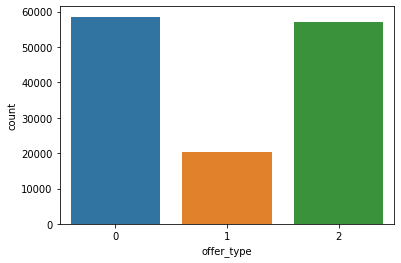

In [575]:
sns.countplot(x = 'offer_type', data=master_df)

#### Create Input and Output Data

In [576]:
# split into X and Y
Y = master_df['offer_type']
X = master_df.drop(['offer_type'], axis=1)

print(X.shape)
print(Y.shape)

# convert to numpy arrays
X = np.asarray(X, dtype=np.float)

(135821, 13)
(135821,)


In [577]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

In [578]:
# work with labels train
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


# work with labels test
# encode class values as integers
encoder_test = LabelEncoder()
encoder_test.fit(y_test)
encoded_Y_test = encoder_test.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

In [579]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(3, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 51        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


In [580]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X_train,
                    dummy_y,
                    callbacks=[es],
                    epochs=5, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/5
8150/8150 [==============================] - 7s 822us/step - loss: 0.0856 - accuracy: 0.9789 - val_loss: 4.6811e-11 - val_accuracy: 1.0000
Epoch 2/5
8150/8150 [==============================] - 7s 813us/step - loss: 2.8391e-11 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
8150/8150 [==============================] - 7s 817us/step - loss: 2.6861e-12 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
8150/8150 [==============================] - 7s 822us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
8150/8150 [==============================] - 7s 815us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


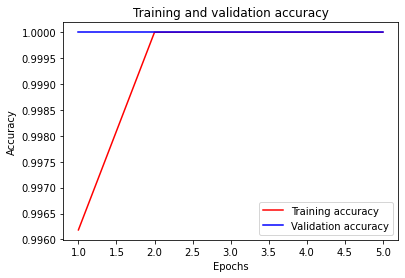

In [581]:
import matplotlib.pyplot as plt

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [582]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X_test) # see how the model did!

matrix = confusion_matrix(dummy_y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[14718,     0,     0],
       [    0,  5014,     0],
       [    0,     0, 14224]])

In [583]:
# more detail on how well things were predicted
print(classification_report(dummy_y_test.argmax(axis=1), preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14718
           1       1.00      1.00      1.00      5014
           2       1.00      1.00      1.00     14224

    accuracy                           1.00     33956
   macro avg       1.00      1.00      1.00     33956
weighted avg       1.00      1.00      1.00     33956



# Algorithm Random Forest

In [584]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# from sklearn.externals import joblib
import joblib
print('Libraries Imported')

Libraries Imported


In [585]:
#Creating the dependent variable class
factor = pd.factorize(master_df['offer_type'])
master_df.offer_type = factor[0]
definitions = factor[1]
print(master_df.offer_type.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: offer_type, dtype: int64
Int64Index([0, 1, 2], dtype='int64')


### Create Input and Output Data

In [586]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

In [587]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [588]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [589]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(4),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species']))


Predicted Species      0     1      2
Actual Species                       
0                  14718     0      0
1                      0  5014      0
2                      0     0  14224


In [590]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


# Conclusion

The ANN and Random Forest althought using different methods, both have reached 100% of accuracy, its show that the approuches used in preproccess steps were very well selected.

To resume, what we did was:
- Study the problem in deeph
- Search in the literature to similar works and find out how other researchs solved similar problems
- Produce a Data Visualization of the attributes
- Preproccess the data, removing out-liers, noises and incomplete informations
- Merge the data sets
- Produce three class to predict
- Implement an ANN with to solve the final dataset
- Implement a Random Forest to solve the final dataset
- Final concludes

# References

- Paper
- https://www.ibm.com/cloud/learn/neural-networks
- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- https://www.techopedia.com/definition/14650/data-preprocessing
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-multi-class-classification-e940f74bd899
- https://builtin.com/data-science/random-forest-algorithm